# Shapley values - prediction of PFS for NSCLC patients with an aggregated radiomic model

In this jupyter notebook we provide a short example for the use of Shapley values to explain aggregated radiomic models. We study the prediction of the progression-free survival (PFS) of metastatic non-small cell lung cancer (NSCLC) patients undergoing immunotherapy, using their baseline 18F-FDG PET images. To do so, we use a radiomic model that aggregates features extracted from all the lesions of the patient.

**Note:** In particular, this notebook will illustrate how to use radshap with custom aggregation functions (i.e., different from the default aggregation functions implemented in radshap such as min, max, mean...).

In [1]:
%load_ext autoreload
%autoreload 2

# Setup for local running - please delete this block
import sys
sys.path.append('C:\\Users\\ncaptier\\Documents\\GitHub\\radshap')

from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.spatial.distance import pdist

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

from lifelines import CoxPHFitter, KaplanMeierFitter
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw, cumulative_dynamic_auc
from sksurv.linear_model import CoxPHSurvivalAnalysis

from radshap.shapley import Shapley
from radshap.plot import plot_pet

## 0. Load radiomic and clinical data

Our cohort gathers **115 NSCLC metastatic patients** with a baseline 18F-FDG PET scan (for the diagnosis of the metastatic disease) acquired before the beginning of their first line immunotherapy. All their metastases were segmented by a 12 years experienced nuclear medicine physician.

**Note:** For each patient we collected their PFS as well as their height and weight at baseline.

In [2]:
df_clinicals = pd.read_csv("..\\data\\data_clinicals_PFS.csv", index_col=0)
df_clinicals.head(0)

,Height,Weight,PFS.event,PFS.time
Patient ID,,,,


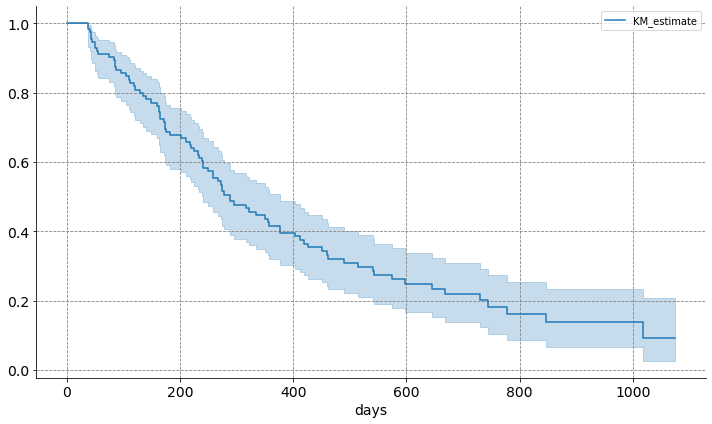

In [3]:
fig, ax = plt.subplots(figsize=(10, 6))

kmf = KaplanMeierFitter()
kmf.fit(df_clinicals["PFS.time"], df_clinicals["PFS.event"])
kmf.plot(ax=ax)

sns.despine()
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.set_tick_params(labelsize=14)
ax.set_xlabel("days", fontsize=14)
ax.yaxis.set_tick_params(labelsize=14)
plt.tight_layout()

For this experiment, we processed the PET images and segmented lesions with 3 steps:   

1. We first resampled all images to a fixed 2x2x2 mm3 voxel size.
2. We applied an absolute threshold of 2.5 standardized uptake value (SUV) units, meaning that all voxel values less than 2.5 were excluded from the segmented tumor regions.
3. For all the remaining lesions we used pyradiomics to extract their volume as well as the coordinates of their center of mass.

In [4]:
# The following dataframe df_radiomics contains the volume and the coordinates of the center of mass of each segmented lesion of each patient (i.e., one row per lesion).

df_radiomics = pd.read_csv("..\\data\\data_allmeta_bis.csv", index_col=[0, 1])
df_radiomics.head(0)

,,CenterOfMass_x,CenterOfMass_y,CenterOfMass_z,original_shape_VoxelVolume
Patient ID,ROI,,,,


## 1. Compute standardized Dmax and TMTV

In this tutorial, we will explore a simple aggregated model that combines two aggregated features: the total metabolic tumor volume (TMTV) and the standardized Dmax (i.e., the maximum Euclidean distance between two lesions divided by the body surface area). These features have already shown promising prognostic and predictive performance in NSCLC and other cancers, such as lymphoma.

Obviously, such simple model could be explained by human intuition alone and radshap is not necessarily required here. However, the purpose of this example is to illustrate how to apply RadShap for survival tasks and also how to use custom aggregation functions with RadShap (i.e., a function to compute the TMTV and sDmax for each subset of lesions).

**Standardized Dmax**

In [5]:
# 1. Compute maximum euclidean distance between two lesions for each patient
def compute_Dmax(df):
    temp = pdist(df)
    if len(temp) > 0:
        return temp.max()
    else:
        return 0

dmax = df_radiomics.iloc[:, :3].groupby(level=0).apply(compute_Dmax)

# 2. Standardize by the  body surface area
temp = pd.concat([df_clinicals, dmax], axis=1, join='inner')
temp.rename(columns = {0: 'Dmax'}, inplace = True)
dmax = (temp['Dmax']/(np.sqrt((temp['Weight'])*(temp['Height'])/3600))).rename("sDmax")

**Total Metabolic Tumor Volume (TMTV)**

In [6]:
tmtv = df_radiomics['original_shape_VoxelVolume'].groupby(level=0).sum().rename("TMTV")

In [7]:
df_agg = pd.concat([tmtv, dmax], axis=1)

# we log-transform the TMTV to avoid linear model to deal with highly right skewed distributions
df_agg["TMTV"] = np.log(df_agg["TMTV"] + 1)

df_agg.head(5)

,TMTV,sDmax
Patient ID,,
patient_1,12.894632,103.954279
patient_10,4.976734,54.800191
patient_100,12.908975,78.014952
patient_101,12.060729,62.903636
patient_102,10.512628,246.422312


## 2. PFS prediction with an aggregated model 

In [8]:
X = df_agg.loc[df_clinicals.index].values
y = Surv.from_dataframe(event="PFS.event", time="PFS.time", data = df_clinicals)

In [9]:
# Aggregated model (scaling + Cox model)
model_agg = Pipeline(steps=[('scaling', StandardScaler()),
                            ('Cox', CoxPHSurvivalAnalysis())])

### 2.1 Train and test Cox models with repeated cross-validation schemes

Here we use a repeated stratified cross-validation scheme with 5 folds and 100 repeats to train and test our Cox model (combining TMTV and sDmax). To do so we first design a custom cross-validation function, **CensoredKFold**, to stratify folds with respect to the censorship rate.

In [10]:
class CensoredKFold(StratifiedKFold):
    
    def _iter_test_masks(self, X, y=None, groups=None):
        return super()._iter_test_masks(X, y["PFS.event"], groups)

In [11]:
preds = []
patient_indexes = df_clinicals.index

for i in tqdm(range(100)):
    cv = CensoredKFold(n_splits=5, shuffle=True, random_state=i)
    predictions = []
    
    for k, (train, test) in enumerate(cv.split(np.zeros(len(y)), y)):
        X_train, y_train, X_test, y_test = X[train, :], y[train], X[test, :], y[test]
        
        # Fit aggregative model
        model = clone(model_agg).fit(X_train, y_train)
        
        # Collect predictions
        temp_preds = pd.DataFrame(model.predict(X_test), columns = ["pred"], index = patient_indexes[test])
        temp_preds['fold'] = k 
        temp_preds["PFS.time"] = y_test["PFS.time"]
        temp_preds["PFS.event"] = y_test["PFS.event"]
        predictions.append(temp_preds)
        
    df_preds = pd.concat(predictions, axis=0)
    df_preds["repeat"] = i
    preds.append(df_preds)

df_predictions = pd.concat(preds, axis=0)
df_predictions.head(5)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.91it/s]


,pred,fold,PFS.time,PFS.event,repeat
Patient ID,,,,,
patient_124,0.370520,0,275.0,True,0
patient_32,-0.036694,0,43.0,True,0
patient_128,0.473378,0,275.0,True,0
patient_50,0.350977,0,174.0,True,0
patient_76,-0.082603,0,160.0,True,0


### 2.2 Compute and display performance results

For each of the 100 repeats with compute two performance metrics with the patient predicted risk scores collected within the different test sets of the cross-validation scheme:
* The Uno's concordance index
* The average time-dependent AUC (tAUC) over the observed time range

**Note 1:** We refer the reader to [this tutorial](https://scikit-survival.readthedocs.io/en/stable/user_guide/evaluating-survival-models.html) for an interesting discussion about the evaluation of the performance of survival models.

In [12]:
# Both Uno's Cindex and time-dependent AUC require estimating the censoring distribution (i.e., "survival_train" parameter). Here we use the whole data set to avoid
# dealing with unconsistent measures across folds.

def _fun_Cindex(data):
    """
    Compute Uno's Concordance index for the risk predictions collected on the test sets of
    a cross-validation scheme.
    """
    y_data = Surv.from_dataframe(event="PFS.event", time="PFS.time", data = data)
    return concordance_index_ipcw(survival_train = y_data, survival_test = y_data, estimate = data["pred"].values)[0]

def _fun_AUC(data):
    """
    Compute average time-dependent AUC for the risk predictions collected on the test sets of
    a cross-validation scheme.
    """
    y_data = Surv.from_dataframe(event="PFS.event", time="PFS.time", data = data)
    times = np.percentile(y_data["PFS.time"], np.linspace(5, 81, 15))
    temp = cumulative_dynamic_auc(survival_train = y_data,
                                  survival_test = y_data,
                                  estimate = data["pred"].values,
                                  times = np.percentile(y_data["PFS.time"], np.linspace(5, 81, 15)))[1]
    return temp
    
results_cind = df_predictions.groupby("repeat").apply(_fun_Cindex).rename("Cindex")
results_auc = df_predictions.groupby("repeat").apply(_fun_AUC).rename("tAUC")

results = pd.concat([results_cind, results_auc], axis=1)

In [13]:
# Mean performance across the 100 cross-validation schemes (+- standard deviation)
mean_perf = results.mean()
std_perf = results.std()

print("Cindex:  mean = " + str(np.round(mean_perf.loc["Cindex"], 3)) + ",  std = " + str(np.round(std_perf.loc["Cindex"], 3)))
print("tAUC:  mean = " + str(np.round(mean_perf.loc["tAUC"], 3)) + ",  std = " + str(np.round(std_perf.loc["tAUC"], 3)))

Cindex:  mean = 0.613,  std = 0.006
tAUC:  mean = 0.653,  std = 0.008


Text(0, 0.5, 'Average value across 100 CV')

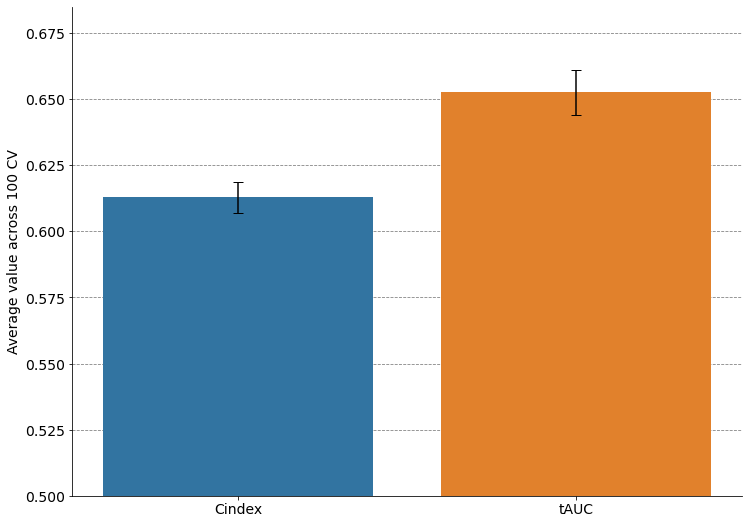

In [14]:
fig, ax = plt.subplots(figsize=(12, 9))

sns.barplot(data = results.melt(), x="variable", y="value", ci=None, ax=ax)

ax.errorbar(x=np.arange(2),
            y=results.mean(axis=0).values,
            yerr=results.std(axis=0).values,
            fmt='none',
            ecolor='k',
            capsize=5,
            elinewidth=1.5)
        
ax.set_ylim(0.5, 0.685)
ax.set(xlabel=None, ylabel=None)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
sns.despine()
ax.set_ylabel("Average value across 100 CV", fontsize=14)

## 3. Interpretation of the aggregated model with Shapley values

Here we use the **radshap package** to explain the predictions of the aggregated radiomic model (i.e., Cox model combining TMTV and standardize Dmax) and highlight the most impactful lesions for each patient.

* We will first retrain the aggregated model on the whole dataset (i.e., 115 NSCLC patients)
* We will apply RadShap to explain the prediction made by this model for a patient of the cohort (i.e., computing the Shapley value associated with each segmented lesion).

In particular, we will illustrate, here, how to define a custom aggregation function to compute the TMTV and standardized Dmax for every subset of segmented ROIs and use it with RadShap to explain our Cox model.

### 3.1 Train an aggregative model on the whole data set

First, we train a Cox model with the whole dataset using the  [lifelines Python package](https://lifelines.readthedocs.io/en/latest/). This package provides access to the *print_summary* function, which nicely displays the hazard ratios for both features, confidence intervals, and the p-values associated with the Wald test.

**Note :** Please note that this step is optional and can be omitted. 

In [15]:
df= pd.concat([df_agg, df_clinicals[["PFS.time", "PFS.event"]]], axis=1)

# 1. Scaling
scaling = StandardScaler()
df.iloc[:, :-2] = scaling.fit_transform(df.iloc[:, :-2])

# 2. Fit the Cox model
model_lifeline = CoxPHFitter()
model_lifeline.fit(df, "PFS.time", "PFS.event")

model_lifeline.print_summary()

<lifelines.CoxPHFitter: fitted with 115 total observations, 31 right-censored observations>
             duration col = 'PFS.time'
                event col = 'PFS.event'
      baseline estimation = breslow
   number of observations = 115
number of events observed = 84
   partial log-likelihood = -325.36
         time fit was run = 2024-04-25 09:09:13 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
TMTV        0.41       1.51       0.12             0.17             0.65                 1.19                 1.91
sDmax       0.20       1.22       0.11            -0.01             0.41                 0.99                 1.50

            cmp to    z      p   -log2(p)
covariate                                
TMTV          0.00 3.38 <0.005      10.45
sDmax         0.00 1.87   0.06       4.01
---
Concordance = 0.63
Partial AIC = 654.72
log-likelihood ratio test = 16.76 on 2 df
-log2(p) of ll-ratio test = 12.09

We now retrain a Cox model on the whole dataset using, this time, the [scikit-survival Python package](https://scikit-survival.readthedocs.io/en/stable/). Indeed, we found that **scikit-survival** and its compatibility with sklearn were easier to deal with here, compared to **lifelines**, particularly for creating pipelines and including the scaling step in the model.

In [16]:
model_all = clone(model_agg).fit(X, y)

# Average prediction over the whole dataset
mean_preds = model_all.predict(X).mean()

### 3.2 Compute Shapley values

**Define a custom aggregation function**

In short, to compute the Shapley values, RadShap considers every possible subset of ROIs, recalculates the aggregated input, and predicts from this new input to assess whether the prediction changes. Thus, we need to provide RadShap with a function to compute the aggregated input for the model of interest using an arbitrary subset of ROIs.

RadShap can automatically manage straightforward functions, such as considering the mean, maximum, or minimum values of radiomic features measured for different ROIs within an image. However, in this case, we need to specify our aggregation function, which involves defining a function that takes an array of size *n_ROIS x n_features* as input and returns an aggregated input corresponding to **(TMTV_subset, sDmax_subset)**.

In [17]:
patient = "patient_79"

#Retrieve weight and height to standardize Dmax
weight, height = df_clinicals.loc[patient, 'Weight'], df_clinicals.loc[patient, 'Height']

def agg_fun(X):
    aggregated_features = np.zeros((1, 2))
    
    #1. Compute TMTV for the subset of ROIs
    aggregated_features[0, 0] = np.log(np.sum(X[:, -1]) + 1)
    
    #2. Compute standardized Dmax for the subset of ROIs
    temp = pdist(X[:, :3])
    if len(temp) > 0:
        aggregated_features[0,1] = temp.max()/(np.sqrt((weight)*(height)/3600))
    else:
        aggregated_features[0,1]

    return aggregated_features

We can now define the RadShap explainer, using the trained aggregated model as input, which uses TMTV and sDmax to make predictions, and the custom aggregation function defined above to compute TMTV and sDmax for every subset of ROIs.

**Note:** RadShap also requires a value for a random prediction, i.e., when no ROIs are considered in the image. Here, we propose estimating such a random prediction by using the average predictions across the dataset. This strategy is notably used within the [SHAP Python package](https://shap.readthedocs.io/en/latest/index.html).

In [18]:
shap = Shapley(predictor = lambda x: model_all.predict(x),
               aggregation = agg_fun,
               empty_value=mean_preds)

We then retrieve the features associated with each lesion of the patient for whom we want to explain the prediction of the aggregated model. Here, the features correspond to the volume and the center of mass of each lesion, resulting in an input *x_explain* for the RadShap explainer of shape *n_lesions x 4*.

In [19]:
x_explain = df_radiomics.loc[patient].values.astype("float")
rois_names = list(df_radiomics.loc[patient].index)

shap_values = shap.explain(x_explain)

Finally, we can visualize the computed Shapley values on the Maximum Intensity Projection (MIP) of the baseline PET image for the patient of interest, using a color scale. As expected, we do observe that, for this patient, the risk score predicted by the aggregated model, which uses both the TMTV and sDmax, is mainly impacted by large and distant lesions.

**Note:** The color scale should be interpreted as follows, the more red a lesion is (i.e., its Shapley value), the more it increases the predicted risk compared to the average predicted risk measured on the whole cohort. Conversely, the more blue a lesion is, the more it decreases the predicted risk compared to the average risk.

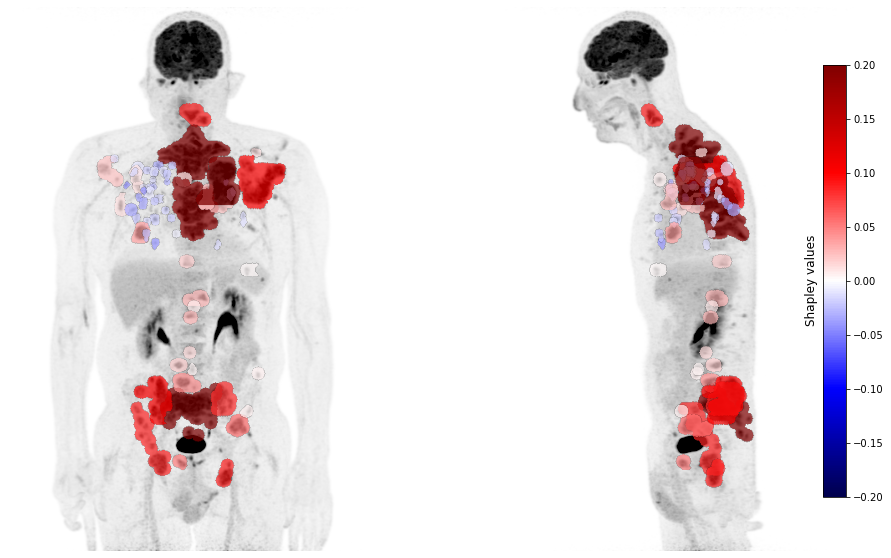

In [20]:
image_path = "E:\\Images\\" + patient + "\\baseline_PET\\PET.nii.gz"
mask_path = "E:\\Images\\" + patient + "\\baseline_PET\\segmentations\\"

mask_paths = []
for name in df_radiomics.loc[patient].index:
    mask_paths.append(mask_path + name + '.uint16.nii.gz')

lim = np.round(np.max(np.abs(shap_values)), 2)
plot_pet(shap_values, image_path=image_path, masks_paths=mask_paths, cmap_lim = lim)